# This is using the wildfire images from the orange dot and manual csv and dates that don't have clouds csv
# Sequential Model
# Image Rotation
# Hyperparameter Tuning

In [2]:
import pandas as pd
import numpy as np
import os

### Get wildfire dates

In [3]:
path = 'image_storage/'
filename = 'wildfires_orange_dot_and_manual.csv'

In [4]:
df_wildfires = pd.read_csv(os.path.join(path, filename))

In [5]:
df_wildfires['date'] = pd.to_datetime(df_wildfires['date'])

In [6]:
df2_wildfires = df_wildfires.sort_values(by='date')

In [7]:
df2_wildfires.dtypes

date         datetime64[ns]
wildfires             int64
dtype: object

In [8]:
df_wildfires['ConvertedDate'] = df2_wildfires['date'].dt.strftime('%Y-%m-%d')

In [9]:
df_wildfires = df_wildfires.drop(['date'], axis = 1)

In [10]:
df_wildfires = df_wildfires.assign(wildfires=1)

In [11]:
df_wildfires = df_wildfires[['ConvertedDate','wildfires']]

In [12]:
len(df_wildfires)

427

### Get dates with minimal cloud coverage
* no_cloudy_dates_list_1_13_2022.csv

In [13]:
path = 'image_storage/'
filename = 'no_cloudy_dates_list_1_13_2022.csv'

In [14]:
df_no_clouds = pd.read_csv(os.path.join(path, filename))

In [15]:
df_no_clouds['date'] = pd.to_datetime(df_no_clouds['Date'])

In [16]:
df_no_clouds = df_no_clouds.drop(['Unnamed: 0'], axis = 1)

In [17]:
df_no_clouds2 = df_no_clouds.sort_values(by='date')

In [18]:
df_no_clouds = df_no_clouds2.drop(['Date'], axis = 1)

In [19]:
df_no_clouds.dtypes

Clouds             int64
date      datetime64[ns]
dtype: object

In [20]:
df_no_clouds['ConvertedDate'] = df_no_clouds['date'].dt.strftime('%Y-%m-%d')

In [21]:
df_no_clouds = df_no_clouds.drop(['date'], axis = 1)

In [22]:
len(df_no_clouds)

3249

In [23]:
df_no_clouds = df_no_clouds[['ConvertedDate','Clouds']]

### Go through df_no_clouds and make sure there are no dates that are also in df_wildfires because the model will need labeled images. The dates in df_no_clouds are just going to be labeled as no wildfire, whereas the dates in df_wildfires will be labeled as wildfire
* Note: For some reason 5 are not in df_dates_in_both idk what is going on with that. I remember looking into it for a long time though

In [24]:
df_dates_in_both = pd.merge(df_no_clouds,df_wildfires, on=['ConvertedDate'],indicator='Exist')

In [25]:
df_no_clouds_no_wildfires = pd.merge(df_no_clouds,df_wildfires,indicator=True,how='outer').query('_merge=="left_only"').drop('_merge',axis=1)

In [26]:
len(df_no_clouds) - len(df_wildfires)

2822

In [27]:
len(df_no_clouds_no_wildfires)

2827

#### df_dates_in_both has a length of 421
#### df_no_clouds has a length of 3249
#### df_wildfires has a length of 426
#### df_no_clouds_no_wildfires has a length of 2828
#### The difference between df_no_clouds and df_wildfires is 2823

### df_no_clouds_no_wildfires should not have any of the dates in df_dates_in_both
* It does not so that is good

## Just need to work with df_wildfires and df_no_clouds_no_wildfires

### Get the dependent variables images

In [28]:
from PIL import Image
from skimage.io import imshow, imread

In [29]:
images_wo_fire_labels_path = 'image_storage/images_wo_fire_labels/'

### Get the images of the dates that have wildfires
#### Pre-Rotating images I didn't have to delete any rows or columns because the x_train, x_test and y_train and y_test were (182, 180, 3)
#### Post-Rotating images I need to make all images (180, 180, 3)

### NOTE:
* I am not going to use from skimage.transform import resize because it keeps the 'bad' images (i.e. the ones that are just black)

### Note:
* I'm leaving this in because some images are black and won't work so this is a cleanser

In [30]:
wildfire_images_cleanse = []

for index, row in df_wildfires.iterrows():
    image_date = row['ConvertedDate']
    jpeg_file = images_wo_fire_labels_path + image_date + '.jpg'
    im = imread(jpeg_file)
    np_im = np.asarray(im)
    np_im = np.delete(np_im,0,1)
    np_im = np.delete(np_im,0,1)
    wildfire_images_cleanse.append(np_im)

In [31]:
# originally had np_im_resize = np.delete(np_im,0,1) twice and it returned (180,181,3)
print(wildfire_images_cleanse[0].shape)

(180, 180, 3)


### Get images of dates that don't have a wildfire or much cloud coverage

In [32]:
no_wildfire_images = []

for index, row in df_no_clouds_no_wildfires.iterrows():
    image_date = row['ConvertedDate']
    jpeg_file = images_wo_fire_labels_path + image_date + '.jpg'
    im = imread(jpeg_file)
    np_im = np.asarray(im)
    np_im = np.delete(np_im,0,1)
    np_im = np.delete(np_im,0,1)
    no_wildfire_images.append(np_im)

In [33]:
print(no_wildfire_images[0].shape)

(180, 180, 3)


### If the images are not the same shape then making the data np arrays will fail and even if you are able to convert them to np arrays the NN will fail
* Inspect the images to ensure the shape sizes are all the same
* This is very interesting because some of the errors have a perfectly fine image
* I realized this because I was searching for this error when trying to fit the NN: 
    * ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type numpy.ndarray)
* I actually realized that when trying to do this:
    * x_train = np.asarray(combined_x_train)
    * x_test = np.asarray(combined_x_test)
    * I was getting this error because not all the shapes were the same size:
        * And I had been seeing this VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

In [34]:
for i in range(len(wildfire_images_cleanse)):
    if wildfire_images_cleanse[i].shape[0] != 180:
        print('error')
    #if wildfire_images[i].shape[1] != 182:
    if wildfire_images_cleanse[i].shape[1] != 180:
        print('i not 182: ', i)
    if wildfire_images_cleanse[i].shape[2] != 3:
        print('i not 3: ', i)

In [35]:
bad_images =[]
for i in range(len(no_wildfire_images)):
    if no_wildfire_images[i].shape[0] != 180 or no_wildfire_images[i].shape[1] != 180 or no_wildfire_images[i].shape[2] != 3:
    #if no_wildfire_images[i].shape[0] != 180 or no_wildfire_images[i].shape[1] != 182 or no_wildfire_images[i].shape[2] != 3:
        #print('i not 180: ', i, 'shape is: ', no_wildfire_images[i].shape[0])
        #print('i not 182: ', i, 'shape is: ', no_wildfire_images[i].shape[1])
        #print('i not 3: ', i, 'shape is: ', no_wildfire_images[i].shape[2])
        bad_images.append(i)

In [36]:
len(bad_images)

26

In [37]:
print(bad_images)

[188, 519, 539, 682, 744, 745, 845, 1015, 1485, 1492, 1493, 1494, 1495, 1496, 1497, 1498, 1499, 1500, 1501, 1502, 1769, 2088, 2096, 2114, 2662, 2786]


In [38]:
# Example just looking at a few previous bad images
df_no_clouds_no_wildfires.loc[188]#: 2013-12-10 image looks fine

ConvertedDate    2010-10-06
Clouds                    0
wildfires               NaN
Name: 188, dtype: object

In [39]:
import matplotlib.pyplot as plt

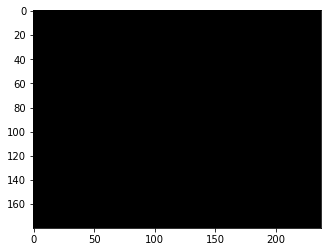

In [40]:
img = plt.imshow(no_wildfire_images[188])

### Drop the "bad" images from no_wildfire_images

In [41]:
no_wildfire_images = []

count = 0
for index, row in df_no_clouds_no_wildfires.iterrows():
    if count not in bad_images:
        image_date = row['ConvertedDate']
        jpeg_file = images_wo_fire_labels_path + image_date + '.jpg'
        im = imread(jpeg_file)
        np_im = np.asarray(im)
        np_im = np.delete(np_im,0,1)
        np_im = np.delete(np_im,0,1)
        no_wildfire_images.append(np_im)
    count+=1

In [42]:
len(no_wildfire_images)

2801

# Get wildfire images
* Get wildfire images without label (426)
* Move left side to right side and right to left of original wildfire image (426)
### Rotate images that have wildfires and move left side to right side and right to left
* 90 degrees (426)
* 90 degrees left to right and right to left (426)
* 180 degrees (426)
* 180 degrees left to right and right to left (426)
* 270 degrees (426)
* 270 degrees left to right and right to left (426)
* After this there will be an additional 2982 (8 * 426) wildfire images, for a total of 3408

In [45]:
wildfire_images_original = []
wildfire_images_original_r_l = []
list_90_rotation = []
list_90_rotation_r_l = []
list_180_rotation = []
list_180_rotation_r_l = []
list_270_rotation = []
list_270_rotation_r_l = []

for index, row in df_wildfires.iterrows():
    image_date = row['ConvertedDate']
    jpeg_file = images_wo_fire_labels_path + image_date + '.jpg'
    im = Image.open(jpeg_file)
    np_im = np.asarray(im)
    np_im = np.delete(np_im,0,1)
    np_im = np.delete(np_im,0,1)
    wildfire_images_original.append(np_im)

    img_left_area = (0,0,90,180)
    img_right_area = (90,0,180,180)
    img_left = im.crop(img_left_area)
    img_right = im.crop(img_right_area)
    new_img = Image.new('RGB',(180,180))
    for i in [img_right, img_left]:
        if i == img_right:
            new_img.paste(i,(0,0))
        else:
            new_img.paste(i,(90,0))
    new_img_array = np.asarray(new_img)
    #new_img_array_less = np.delete(new_img_array,0,0)
    #new_img_array_less = np.delete(new_img_array,0,0)
    wildfire_images_original_r_l.append(new_img_array)
    
    # 90
    im_90_rotation = im.rotate(90, expand = True)
    np_im_90_rotation = np.asarray(im_90_rotation)
    np_im_90_rotation = np.delete(np_im_90_rotation,0,0)
    np_im_90_rotation = np.delete(np_im_90_rotation,0,0)
    list_90_rotation.append(np_im_90_rotation)
    # Moving left side to right side and right side to left side
    img_left_90 = im_90_rotation.crop(img_left_area)
    img_right_90 = im_90_rotation.crop(img_right_area)
    new_img_90 = Image.new('RGB',(180,180))
    for i in [img_right_90, img_left_90]:
        if i == img_right_90:
            new_img_90.paste(i,(0,0))
        else:
            new_img_90.paste(i,(90,0))
    new_img_array_90 = np.asarray(new_img_90)
    #new_img_array_90_rotation = np.delete(new_img_array_90,0,0)
    #new_img_array_90_rotation = np.delete(new_img_array_90,0,0)
    list_90_rotation_r_l.append(new_img_array_90)    
    
    # 180
    im_180_rotation = im.rotate(180, expand = True)
    np_im_180_rotation = np.asarray(im_180_rotation)
    np_im_180_rotation = np.delete(np_im_180_rotation,0,1)
    np_im_180_rotation = np.delete(np_im_180_rotation,0,1)
    list_180_rotation.append(np_im_180_rotation)
    # Moving left side to right side and right side to left side
    img_left_180 = im_180_rotation.crop(img_left_area)
    img_right_180 = im_180_rotation.crop(img_right_area)
    new_img_180 = Image.new('RGB',(180,180))
    for i in [img_right_180, img_left_180]:
        if i == img_right_180:
            new_img_180.paste(i,(0,0))
        else:
            new_img_180.paste(i,(90,0))
    new_img_array_180 = np.asarray(new_img_180)
    #new_img_array_180_rotation = np.delete(new_img_array_180,0,1)
    #new_img_array_180_rotation = np.delete(new_img_array_180,0,1)
    list_180_rotation_r_l.append(new_img_array_180) 
    
    # 270
    im_270_rotation = im.rotate(270, expand = True)
    np_im_270_rotation = np.asarray(im_270_rotation)
    np_im_270_rotation = np.delete(np_im_270_rotation,0,0)
    np_im_270_rotation = np.delete(np_im_270_rotation,0,0)
    list_270_rotation.append(np_im_270_rotation)
    # Moving left side to right side and right side to left side
    img_left_270 = im_270_rotation.crop(img_left_area)
    img_right_270 = im_270_rotation.crop(img_right_area)
    new_img_270 = Image.new('RGB',(180,180))
    for i in [img_right_270, img_left_270]:
        if i == img_right_270:
            new_img_270.paste(i,(0,0))
        else:
            new_img_270.paste(i,(90,0))
    new_img_array_270 = np.asarray(new_img_270)
    #new_img_array_270_rotation = np.delete(new_img_array_270,0,0)
    #new_img_array_270_rotation = np.delete(new_img_array_270,0,0)
    list_270_rotation_r_l.append(new_img_array_270)

In [46]:
array_wildfire_images_original = np.asarray(wildfire_images_original)
array_wildfire_images_original_r_l = np.asarray(wildfire_images_original_r_l)
array_90_rotation = np.asarray(list_90_rotation)
array_90_rotation_r_l = np.asarray(list_90_rotation_r_l)
array_180_rotation = np.asarray(list_180_rotation)
array_180_rotation_r_l = np.asarray(list_180_rotation_r_l)
array_270_rotation = np.asarray(list_270_rotation)
array_270_rotation_r_l = np.asarray(list_270_rotation_r_l)

In [47]:
#Get the shape 

print('array_wildfire_images_original shape: ', array_wildfire_images_original.shape)
print('array_wildfire_images_original shape: ', array_wildfire_images_original[0].shape)
print('array_wildfire_images_original shape_r_l: ', array_wildfire_images_original_r_l.shape)
print('array_wildfire_images_original shape_r_l: ', array_wildfire_images_original_r_l[0].shape)
print('90 rotation shape:', array_90_rotation.shape)
print('90 rotation shape:', array_90_rotation[0].shape)
print('array_90_rotation_r_l shape:', array_90_rotation_r_l.shape)
print('array_90_rotation_r_l shape:', array_90_rotation_r_l[0].shape)
print('180 rotation shape:', array_180_rotation.shape)
print('180 rotation shape:', array_180_rotation[0].shape)
print('array_180_rotation_r_l shape:', array_180_rotation_r_l.shape)
print('array_180_rotation_r_l shape:', array_180_rotation_r_l[0].shape)

print('270 rotation shape:', array_270_rotation.shape)
print('270 rotation shape:', array_270_rotation[0].shape)
print('array_270_rotation_r_l shape:', array_270_rotation_r_l.shape)
print('array_270_rotation_r_l shape:', array_270_rotation_r_l[0].shape)
print(type(array_wildfire_images_original))
print(type(array_wildfire_images_original[0]))
print(type(array_wildfire_images_original_r_l))
print(type(array_wildfire_images_original_r_l[0]))
print(type(array_90_rotation))
print(type(array_90_rotation[0]))
print(type(array_90_rotation_r_l))
print(type(array_90_rotation_r_l[0]))
print(type(array_180_rotation))
print(type(array_180_rotation[0]))
print(type(array_180_rotation_r_l))
print(type(array_180_rotation_r_l[0]))
print(type(array_270_rotation))
print(type(array_270_rotation[0]))
print(type(array_270_rotation_r_l))
print(type(array_270_rotation_r_l[0]))

array_wildfire_images_original shape:  (427, 180, 180, 3)
array_wildfire_images_original shape:  (180, 180, 3)
array_wildfire_images_original shape_r_l:  (427, 180, 180, 3)
array_wildfire_images_original shape_r_l:  (180, 180, 3)
90 rotation shape: (427, 180, 180, 3)
90 rotation shape: (180, 180, 3)
array_90_rotation_r_l shape: (427, 180, 180, 3)
array_90_rotation_r_l shape: (180, 180, 3)
180 rotation shape: (427, 180, 180, 3)
180 rotation shape: (180, 180, 3)
array_180_rotation_r_l shape: (427, 180, 180, 3)
array_180_rotation_r_l shape: (180, 180, 3)
270 rotation shape: (427, 180, 180, 3)
270 rotation shape: (180, 180, 3)
array_270_rotation_r_l shape: (427, 180, 180, 3)
array_270_rotation_r_l shape: (180, 180, 3)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'nump

# Combine images into one wildfire_images list

In [48]:
wildfire_images = []
all_images_arrays = [array_wildfire_images_original,array_wildfire_images_original_r_l,
                    array_90_rotation, array_90_rotation_r_l, array_180_rotation, array_180_rotation_r_l,
                    array_270_rotation, array_270_rotation_r_l]

for i in all_images_arrays:
    for j in i:
        wildfire_images.append(j)

In [49]:
print(len(wildfire_images))

3416


# Add 615 rotated images to no_wildfire_images because there are 2801 right now

In [83]:
list_no_wildfire_images_original = []
list_90_rotation_no_wildfires = []
list_180_rotation_no_wildfires = []
list_270_rotation_no_wildfires = []

count = 0
for index, row in df_no_clouds_no_wildfires.iterrows():
    if count not in bad_images:
        image_date = row['ConvertedDate']
        jpeg_file = images_wo_fire_labels_path + image_date + '.jpg'
        im = Image.open(jpeg_file)
        np_im = np.asarray(im)
        np_im = np.delete(np_im,0,1)
        np_im = np.delete(np_im,0,1)
        list_no_wildfire_images_original.append(np_im)

        # 90
        im_90_rotation = im.rotate(90, expand = True)
        np_im_90_rotation = np.asarray(im_90_rotation)
        np_im_90_rotation = np.delete(np_im_90_rotation,0,0)
        np_im_90_rotation = np.delete(np_im_90_rotation,0,0)
        list_90_rotation_no_wildfires.append(np_im_90_rotation)   

        # 180
        im_180_rotation = im.rotate(180, expand = True)
        np_im_180_rotation = np.asarray(im_180_rotation)
        np_im_180_rotation = np.delete(np_im_180_rotation,0,1)
        np_im_180_rotation = np.delete(np_im_180_rotation,0,1)
        list_180_rotation_no_wildfires.append(np_im_180_rotation)

        # 270
        im_270_rotation = im.rotate(270, expand = True)
        np_im_270_rotation = np.asarray(im_270_rotation)
        np_im_270_rotation = np.delete(np_im_270_rotation,0,0)
        np_im_270_rotation = np.delete(np_im_270_rotation,0,0)
        list_270_rotation_no_wildfires.append(np_im_270_rotation)
         
    count+=1

In [84]:
array_no_wildfire_images = np.asarray(list_no_wildfire_images_original)
array_90_rotation_no_wildfires = np.asarray(list_90_rotation_no_wildfires)
array_180_rotation_no_wildfires = np.asarray(list_180_rotation_no_wildfires)
array_270_rotation_no_wildfires = np.asarray(list_270_rotation_no_wildfires)

In [86]:
#Get the shape 
# no_wildfire_images

print('no_wildfire_images shape: ', array_no_wildfire_images.shape)
print('no_wildfire_images shape: ', array_no_wildfire_images[0].shape)
print('array_90_rotation_no_wildfires shape:', array_90_rotation_no_wildfires.shape)
print('array_90_rotation_no_wildfires shape:', array_90_rotation_no_wildfires[0].shape)
print('array_180_rotation_no_wildfires shape:', array_180_rotation_no_wildfires.shape)
print('array_180_rotation_no_wildfires shape:', array_180_rotation_no_wildfires[0].shape)

print('array_270_rotation_no_wildfires shape:', array_270_rotation_no_wildfires.shape)
print('array_270_rotation_no_wildfires shape:', array_270_rotation_no_wildfires[0].shape)
print(type(array_no_wildfire_images))
print(type(array_no_wildfire_images[0]))
print(type(array_90_rotation_no_wildfires))
print(type(array_90_rotation_no_wildfires[0]))
print(type(array_180_rotation_no_wildfires))
print(type(array_180_rotation_no_wildfires[0]))
print(type(array_270_rotation_no_wildfires))
print(type(array_270_rotation_no_wildfires[0]))

no_wildfire_images shape:  (2801, 180, 180, 3)
no_wildfire_images shape:  (180, 180, 3)
array_90_rotation_no_wildfires shape: (2801, 180, 180, 3)
array_90_rotation_no_wildfires shape: (180, 180, 3)
array_180_rotation_no_wildfires shape: (2801, 180, 180, 3)
array_180_rotation_no_wildfires shape: (180, 180, 3)
array_270_rotation_no_wildfires shape: (2801, 180, 180, 3)
array_270_rotation_no_wildfires shape: (180, 180, 3)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


# Combine images into one no_wildfire_images list
* Just doing a few hundred from each of the rotated images

In [87]:
no_wildfire_images = []
all_images_arrays = [array_no_wildfire_images,array_90_rotation_no_wildfires[:205],
                    array_180_rotation_no_wildfires[:205], array_270_rotation_no_wildfires[:205]]

for i in all_images_arrays:
    for j in i:
        no_wildfire_images.append(j)

### Make sure images have the correct shape: (180, 180, 3)

In [82]:
not_180_0 = 0
not_180_1 = 0
not_3 = 0
for i in range(len(wildfire_images)):
    if wildfire_images[i].shape[0] != 180:
        not_180_0 += 1
    if wildfire_images[i].shape[1] != 180:
        not_180_1 += 1
    if wildfire_images[i].shape[2] != 3:
        not_3 += 1
print(not_180_0)
print(not_180_1)
print(not_3)

0
0
0


In [89]:
len(no_wildfire_images)

3416

In [90]:
not_180_0 = 0
not_180_1 = 0
not_3 = 0
for i in range(len(no_wildfire_images)):
    if wildfire_images[i].shape[0] != 180:
        not_180_0 += 1
    if wildfire_images[i].shape[1] != 180:
        not_180_1 += 1
    if wildfire_images[i].shape[2] != 3:
        not_3 += 1
print(not_180_0)
print(not_180_1)
print(not_3)

0
0
0


### Get the independent and dependent variable images

In [91]:
x_all_images = wildfire_images + no_wildfire_images
print(len(x_all_images))

6832


In [92]:
y_wildfires = []
for i in range(len(wildfire_images)):
    y_wildfires.append(1)

In [93]:
y_no_wildfires = []
for i in range(len(no_wildfire_images)):
    y_no_wildfires.append(0)

In [94]:
y_all = y_wildfires + y_no_wildfires
print(len(y_all))

6832


In [95]:
import numpy as np
from sklearn.model_selection import train_test_split

In [96]:
X_train, X_test, y_train, y_test = train_test_split(x_all_images, y_all, test_size=0.20, random_state=42)

### Make data a numpy array

In [97]:
import numpy as np

In [98]:
print(type(X_train))
print(type(X_train[0]))
print(X_train[0].shape)

<class 'list'>
<class 'numpy.ndarray'>
(180, 180, 3)


In [99]:
x_train = np.asarray(X_train)
x_test = np.asarray(X_test)

In [100]:
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

In [101]:
print('type(x_train): ',type(x_train))
print('len(x_train): ',len(x_train))
print('type(x_train[0]): ',type(x_train[0]))
print('type(x_test): ',type(x_test))
print('len(x_test): ',len(x_test))
print('type(x_test[0]): ',type(x_test[0]))
print('type(y_train): ',type(y_train))
print('len(y_train): ', len(y_train))
print('type(y_train[0]): ',type(y_train[0]))
print('y_train[0]: ',y_train[0])
print('type(y_test): ',type(y_test))
print('len(y_test): ',len(y_test))
print('type(y_test[0]): ',type(y_test[0]))
print('y_test[0]: ',y_test[0])

type(x_train):  <class 'numpy.ndarray'>
len(x_train):  5465
type(x_train[0]):  <class 'numpy.ndarray'>
type(x_test):  <class 'numpy.ndarray'>
len(x_test):  1367
type(x_test[0]):  <class 'numpy.ndarray'>
type(y_train):  <class 'numpy.ndarray'>
len(y_train):  5465
type(y_train[0]):  <class 'numpy.int64'>
y_train[0]:  1
type(y_test):  <class 'numpy.ndarray'>
len(y_test):  1367
type(y_test[0]):  <class 'numpy.int64'>
y_test[0]:  1


___

### Import libraries for ML

In [102]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras import layers
#from keras.utils import to_categorical
plt.style.use('fivethirtyeight')

### Shape

In [103]:
#Get the shape of x_train
print('x_train shape:', x_train.shape)
#Get the shape of y_train
print('y_train shape:', y_train.shape)
#Get the shape of x_train
print('x_test shape:', x_test.shape)
#Get the shape of y_train
print('y_test shape:', y_test.shape)

x_train shape: (5465, 180, 180, 3)
y_train shape: (5465,)
x_test shape: (1367, 180, 180, 3)
y_test shape: (1367,)


In [104]:
# First image. Shows the image as a series of pixel values
#x_train[0]

In [105]:
# Looking at the first image using matplotlib
# This doesn't work when you convert the values to astype(np.float32)
#img = plt.imshow(x_train[0])

In [106]:
# Print the label of the image. It is either a 0, no wildfire, or 1, wildfire
print('label of the image: ', y_train[0])

label of the image:  1


### Convert labels to a set of 2 numbers using one-hot encoding to input into the NN

In [684]:
#from tensorflow.keras.utils import to_categorical

In [685]:
#y_train_one_hot = to_categorical(y_train)
#y_test_one_hot = to_categorical(y_test)

In [686]:
#print('label of the image: ', y_train_one_hot[0])

### Normalize the pixels

In [107]:
x_train = x_train / 255
x_test = x_test / 255

In [108]:
#Get the shape of x_train
print('x_train shape:', x_train.shape)
#Get the shape of y_train
print('y_train shape:', y_train.shape)
#Get the shape of x_train
print('x_test shape:', x_test.shape)
#Get the shape of y_train
print('y_test shape:', y_test.shape)

x_train shape: (5465, 180, 180, 3)
y_train shape: (5465,)
x_test shape: (1367, 180, 180, 3)
y_test shape: (1367,)


In [689]:
#x_train[0]

# Hyperparameter Tuning

# Hypermodel
* Puts together the whole hyperparameter search space and does hyperparameter tuning

In [1]:
# pip install keras-tuner

In [110]:
from keras_tuner import HyperModel

In [112]:
from tensorflow import keras
from tensorflow.keras.layers import (
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    MaxPooling2D
)

In [113]:
input_shape=(180,180,3)
num_classes = 2

In [114]:
model = keras.Sequential()

In [ ]:
# I used sparse categorical cross entropy because I didn't one-hot encode y_train and y_test
# Sparse Categorical Cross Entropy is a loss function used in machine learning for multiclass classification problems. It is particularly useful when the target labels are integers rather than one-hot encoded vectors. This loss function computes the cross-entropy loss between the true labels and the predicted probabilities, but it works directly with integer labels, saving the step of converting them to one-hot encoded vectors.

# Key Principles

# Cross-Entropy Loss: Measures the performance of a classification model whose output is a probability value between 0 and 1. It increases as the predicted probability diverges from the actual label.

# Sparse Representation: Instead of using one-hot encoding, the labels are represented as integers, which is more memory efficient and simplifies the computation.

In [115]:
class CNNHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        model = keras.Sequential()
        model.add(
            Conv2D(filters=16,kernel_size=3,activation='relu',input_shape=self.input_shape)
        )
        model.add(
            Conv2D(filters=16,activation='relu',kernel_size=3)
        )
        model.add(MaxPooling2D(pool_size=2))
        model.add(
            Dropout(rate=hp.Float('dropout_1',min_value=0.0,max_value=0.5,default=0.3,step=0.1,))
        )
        model.add(
            Conv2D(filters=32,kernel_size=3,activation='relu')
        )
        model.add(
            Conv2D(filters=hp.Choice('num_filters',values=[32, 64],default=64,),activation='relu',kernel_size=3)
        )
        model.add(MaxPooling2D(pool_size=2))
        model.add(
            Dropout(rate=hp.Float('dropout_2',min_value=0.0,max_value=0.5,default=0.3,step=0.1,))
        )
        model.add(Flatten())
        model.add(
            Dense(units=hp.Int('units',min_value=64,max_value=512,step=32,default=128),
                activation=hp.Choice('dense_activation',values=['relu', 'tanh', 'sigmoid'],default='relu'))
        )
        model.add(
            Dropout(rate=hp.Float('dropout_3',min_value=0.0,max_value=0.5,default=0.3,step=0.1))
        )
        model.add(Dense(self.num_classes, activation='softmax'))

        model.compile(
            optimizer=keras.optimizers.Adam(
                hp.Float('learning_rate',min_value=1e-4,max_value=1e-2,sampling='LOG',default=1e-3)
            ),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        return model

hypermodel = CNNHyperModel(input_shape=input_shape, num_classes=num_classes)

### Choose the Tuner
### Hyperband
* Optimized version of random search
* Uses early-stopping to speed up the hyperparameter tuning process. 
* Main idea is to fit a large number of models for a small number of epochs and to only continue training for the models achieving the highest accuracy on the validation set

In [116]:
from keras_tuner.tuners import Hyperband

In [117]:
HYPERBAND_MAX_TRIALS = 40
EXECUTION_PER_TRIAL = 2
HYPERBAND_MAX_EPOCHS = 10
SEED = 1
tuner = Hyperband(
    hypermodel,
    max_epochs=HYPERBAND_MAX_EPOCHS,
    objective='val_accuracy',
    seed=SEED,
    executions_per_trial=EXECUTION_PER_TRIAL,
    directory='hyperband_3_28',
    project_name='test1'
)

### Summary of model hyperparameters

In [118]:
tuner.search_space_summary()

Search space summary
Default search space size: 7
dropout_1 (Float)
{'default': 0.3, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
num_filters (Choice)
{'default': 64, 'conditions': [], 'values': [32, 64], 'ordered': True}
dropout_2 (Float)
{'default': 0.3, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
units (Int)
{'default': 128, 'conditions': [], 'min_value': 64, 'max_value': 512, 'step': 32, 'sampling': None}
dense_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
dropout_3 (Float)
{'default': 0.3, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


### Tuning the algorithm to make a model
* .search(): Evaluates hyperparameter combination
    * NOTE: epochs parameter is used in random search and Bayesian Optimization

In [119]:
N_EPOCH_SEARCH = 40

tuner.search(x_train, y_train, epochs=N_EPOCH_SEARCH, validation_split=0.2)

Trial 30 Complete [00h 29m 17s]
val_accuracy: 0.9263494908809662

Best val_accuracy So Far: 0.9295516908168793
Total elapsed time: 06h 14m 55s
INFO:tensorflow:Oracle triggered exit


### Display Results

In [120]:
# Show a summary of the search
tuner.results_summary()

# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model.
loss, accuracy = best_model.evaluate(x_test, y_test)

Results summary
Results in hyperband_3_28/test1
Showing 10 best trials
Trial summary
Hyperparameters:
dropout_1: 0.0
num_filters: 64
dropout_2: 0.1
units: 448
dense_activation: tanh
dropout_3: 0.30000000000000004
learning_rate: 0.00013607174450468629
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0012
Score: 0.9295516908168793
Trial summary
Hyperparameters:
dropout_1: 0.0
num_filters: 32
dropout_2: 0.30000000000000004
units: 288
dense_activation: tanh
dropout_3: 0.2
learning_rate: 0.0009719978423652108
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.928636759519577
Trial summary
Hyperparameters:
dropout_1: 0.2
num_filters: 32
dropout_2: 0.4
units: 384
dense_activation: tanh
dropout_3: 0.5
learning_rate: 0.000254849985227742
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.9263494908809662
Trial summary
Hyperparameters:
dropout_1: 0.2
num_filters: 64
dropout_2: 0.30000000000000004
u

In [2]:
#print(tuner.get_best_models())

# To save the best model (or at least a model)
* https://towardsdatascience.com/keras-callbacks-and-how-to-save-your-model-from-overtraining-244fc1de8608

In [122]:
from keras.callbacks import ModelCheckpoint

In [123]:
filepath = 'hyperband_3_28.hdf5'

In [124]:
# val_loss = mode = min, val_acc = mode = max
checkpoint = ModelCheckpoint(filepath=filepath,
                            monitor='val_loss',
                            verbose=1,
                            save_best_only=True,
                            mode='min')

In [125]:
callbacks = [checkpoint]

In [126]:
hist = best_model.fit(x_train, 
                 y_train, 
                 batch_size=256, 
                 epochs=10, 
                 validation_split=0.2,
                     callbacks=callbacks)

Epoch 1/10
18/18 [==============================] - ETA: 0s - loss: 0.1227 - accuracy: 0.9600
Epoch 00001: val_loss improved from inf to 0.20221, saving model to hyperband_3_28.hdf5
18/18 [==============================] - 96s 5s/step - loss: 0.1227 - accuracy: 0.9600 - val_loss: 0.2022 - val_accuracy: 0.9305
Epoch 2/10
18/18 [==============================] - ETA: 0s - loss: 0.1174 - accuracy: 0.9611
Epoch 00002: val_loss did not improve from 0.20221
18/18 [==============================] - 90s 5s/step - loss: 0.1174 - accuracy: 0.9611 - val_loss: 0.2109 - val_accuracy: 0.9360
Epoch 3/10
18/18 [==============================] - ETA: 0s - loss: 0.1138 - accuracy: 0.9581
Epoch 00003: val_loss did not improve from 0.20221
18/18 [==============================] - 93s 5s/step - loss: 0.1138 - accuracy: 0.9581 - val_loss: 0.2134 - val_accuracy: 0.9268
Epoch 4/10
18/18 [==============================] - ETA: 0s - loss: 0.1132 - accuracy: 0.9618
Epoch 00004: val_loss did not improve from 0.20

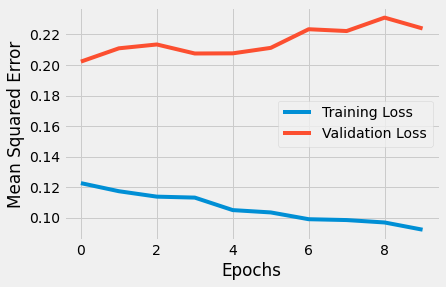

In [127]:
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.show()

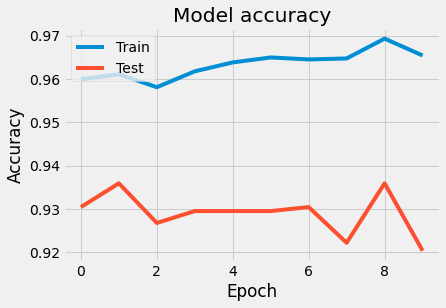

In [128]:
#Visualize the models accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [129]:
best_model.evaluate(x_test, y_test)[0]

43/43 [==============================] - 7s 153ms/step - loss: 0.2582 - accuracy: 0.9108


0.2581723928451538

# ACCORDING TO THE DOCUMENTATION OF MODELCHECKPOINT
* https://keras.io/api/callbacks/model_checkpoint/
* you're supposed to do:
1. compile
2. modelcheckpoint()
3. model.fit()
4. model.load_weights

# Model Validation
* I should have pulled out a few pictures then checked the results because these may have been in train

In [130]:
print(len(df_no_clouds_no_wildfires))

2827


### Get random index values from df_no_clouds_no_wildfires and df_wildfires

In [131]:
import random

In [132]:
df_wildfires_index_values = []
for i in df_wildfires.index:
    df_wildfires_index_values.append(i)
random_wildfire_images = [random.choice(df_wildfires_index_values),random.choice(df_wildfires_index_values),
                random.choice(df_wildfires_index_values),random.choice(df_wildfires_index_values)]
print(random_wildfire_images)

[117, 395, 285, 117]


In [133]:
df_no_clouds_no_wildfires_index_values = []
for i in df_no_clouds_no_wildfires.index:
    df_no_clouds_no_wildfires_index_values.append(i)
random_no_clouds_no_wildfires_images = [random.choice(df_no_clouds_no_wildfires_index_values),random.choice(df_no_clouds_no_wildfires_index_values),
                random.choice(df_no_clouds_no_wildfires_index_values),random.choice(df_no_clouds_no_wildfires_index_values)]
print(random_no_clouds_no_wildfires_images)

[393, 2393, 2907, 276]


In [134]:
# Load an image you want to classify from an image file
# I'm just getting 4 random dates where there are no wildfires and where there were wildfires
fire_1 = df_wildfires['ConvertedDate'][random_wildfire_images[0]]
fire_2 = df_wildfires['ConvertedDate'][random_wildfire_images[1]]
fire_3 = df_wildfires['ConvertedDate'][random_wildfire_images[2]]
fire_4 = df_wildfires['ConvertedDate'][random_wildfire_images[3]]
no_fire_1 = df_no_clouds_no_wildfires['ConvertedDate'][random_no_clouds_no_wildfires_images[0]]
no_fire_2 = df_no_clouds_no_wildfires['ConvertedDate'][random_no_clouds_no_wildfires_images[1]]
no_fire_3 = df_no_clouds_no_wildfires['ConvertedDate'][random_no_clouds_no_wildfires_images[2]]
no_fire_4 = df_no_clouds_no_wildfires['ConvertedDate'][random_no_clouds_no_wildfires_images[3]]

In [135]:
no_fire_validation_dates = [no_fire_1,no_fire_2,no_fire_3,no_fire_4]
fire_validation_dates = [fire_1,fire_2,fire_3,fire_4]

In [136]:
no_fire_validation_dates

['2011-08-28', '2018-11-01', '2020-10-11', '2011-03-31']

In [137]:
no_wildfire_images_validation = []

for i in no_fire_validation_dates:
    jpeg_file = images_wo_fire_labels_path + i + '.jpg'
    im = imread(jpeg_file)
    no_wildfire_images_validation.append(im)

In [138]:
wildfire_images_validation = []

for i in fire_validation_dates:
    jpeg_file = images_wo_fire_labels_path + i + '.jpg'
    im = imread(jpeg_file)
    wildfire_images_validation.append(im)

#### Resize Images for prediction

In [139]:
from skimage.transform import resize

In [140]:
resized_images_no_fire = []

for i in range(len(no_wildfire_images_validation)):
    #resized_images_no_fire.append(resize(no_wildfire_images_validation[i],(180,182,3)))
    resized_images_no_fire.append(resize(no_wildfire_images_validation[i],(180,180,3)))

In [141]:
# These should all be No wildfire
actual_wildfire_predictions = []
for i in range(len(resized_images_no_fire)):
    actual_wildfire_predictions.append(best_model.predict(np.array([resized_images_no_fire[i]])))
#no_wildfire_prediction_1 = model.predict(np.array([resized_images_no_fire[0]]))

In [142]:
actual_wildfire_predictions

[array([[0.9505394 , 0.04946056]], dtype=float32),
 array([[0.8483778 , 0.15162219]], dtype=float32),
 array([[0.69992477, 0.30007523]], dtype=float32),
 array([[0.9969272 , 0.00307283]], dtype=float32)]

### Look at the images to see if there should be no wildfire

#### Get the labeled images for the specified dates

In [143]:
images_w_fire_labels_path = '/images_w_fire_labels/'

In [144]:
wildfire_images_w_label = []

for i in no_fire_validation_dates:
    jpeg_file = images_w_fire_labels_path + i + '.jpg'
    im = imread(jpeg_file)
    wildfire_images_w_label.append(im)

In [145]:
actual_wildfire_predictions[0]

array([[0.9505394 , 0.04946056]], dtype=float32)

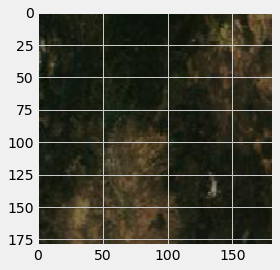

In [146]:
no_wildfire_image_0 = plt.imshow(no_wildfire_images_validation[0])

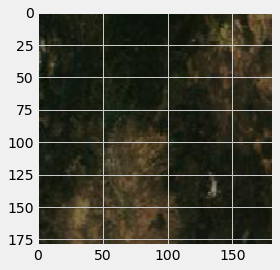

In [147]:
labeled_no_wildfire_image_0 = plt.imshow(wildfire_images_w_label[0])

In [148]:
actual_wildfire_predictions[1]

array([[0.8483778 , 0.15162219]], dtype=float32)

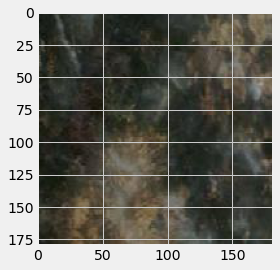

In [149]:
no_wildfire_image_1 = plt.imshow(no_wildfire_images_validation[1])

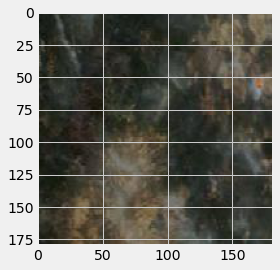

In [150]:
labeled_no_wildfire_image_1 = plt.imshow(wildfire_images_w_label[1])

In [151]:
actual_wildfire_predictions[2]

array([[0.69992477, 0.30007523]], dtype=float32)

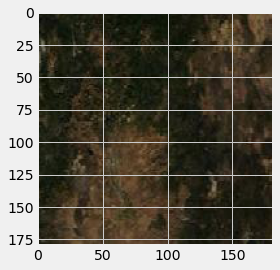

In [152]:
no_wildfire_image_2 = plt.imshow(no_wildfire_images_validation[2])

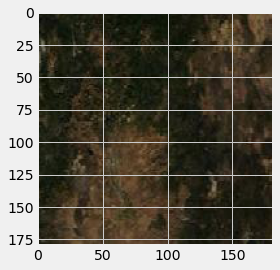

In [153]:
labeled_no_wildfire_image_2 = plt.imshow(wildfire_images_w_label[2])

In [154]:
actual_wildfire_predictions[3]

array([[0.9969272 , 0.00307283]], dtype=float32)

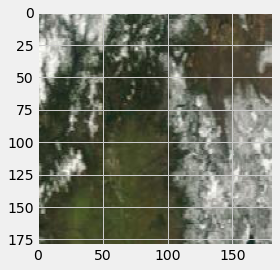

In [155]:
no_wildfire_image_3 = plt.imshow(no_wildfire_images_validation[3])

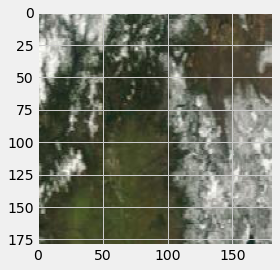

In [156]:
labeled_no_wildfire_image_3 = plt.imshow(wildfire_images_w_label[3])

### The below images were predicted to have wildfire and the labeled data should have the orange dot if there actually was a wildfire

In [157]:
resized_images_w_fire = []

for i in range(len(wildfire_images_validation)):
    #resized_images_w_fire.append(resize(wildfire_images_validation[i],(180,182,3)))
    resized_images_w_fire.append(resize(wildfire_images_validation[i],(180,180,3)))

In [158]:
# These should all be wildfire
actual_wildfire_predictions2 = []
for i in range(len(resized_images_w_fire)):
    actual_wildfire_predictions2.append(best_model.predict(np.array([resized_images_w_fire[i]])))
#no_wildfire_prediction_1 = model.predict(np.array([resized_images_no_fire[0]]))

In [159]:
actual_wildfire_predictions2

[array([[0.87654287, 0.1234572 ]], dtype=float32),
 array([[0.00757095, 0.9924291 ]], dtype=float32),
 array([[0.91819906, 0.08180093]], dtype=float32),
 array([[0.87654287, 0.1234572 ]], dtype=float32)]

#### Get the labeled data images

In [160]:
wildfire_images_w_label_2 = []

for i in fire_validation_dates:
    jpeg_file = images_w_fire_labels_path + i + '.jpg'
    im = imread(jpeg_file)
    wildfire_images_w_label_2.append(im)

In [161]:
actual_wildfire_predictions2[0]

array([[0.87654287, 0.1234572 ]], dtype=float32)

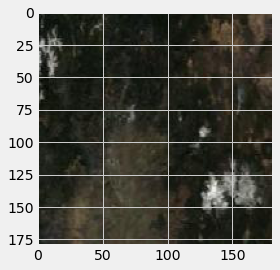

In [162]:
wildfire_image_0 = plt.imshow(wildfire_images_validation[0])

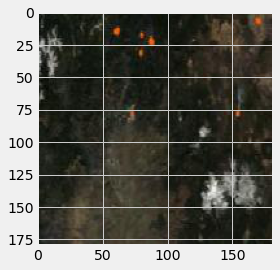

In [163]:
labeled_wildfire_image_0 = plt.imshow(wildfire_images_w_label_2[0])

In [164]:
actual_wildfire_predictions2[1]

array([[0.00757095, 0.9924291 ]], dtype=float32)

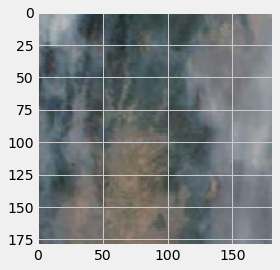

In [165]:
wildfire_image_1 = plt.imshow(wildfire_images_validation[1])

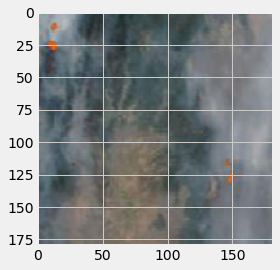

In [166]:
labeled_wildfire_image_1 = plt.imshow(wildfire_images_w_label_2[1])

In [167]:
actual_wildfire_predictions2[2]

array([[0.91819906, 0.08180093]], dtype=float32)

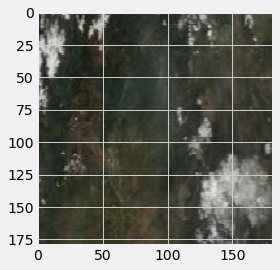

In [168]:
wildfire_image_2 = plt.imshow(wildfire_images_validation[2])

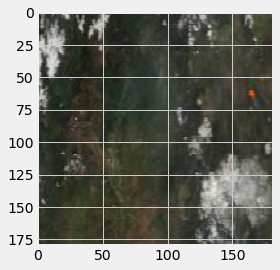

In [169]:
labeled_wildfire_image_2 = plt.imshow(wildfire_images_w_label_2[2])

In [170]:
actual_wildfire_predictions2[3]

array([[0.87654287, 0.1234572 ]], dtype=float32)

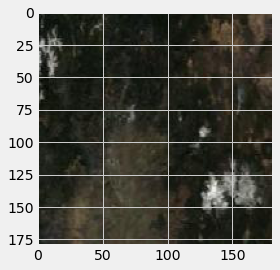

In [171]:
wildfire_image_3 = plt.imshow(wildfire_images_validation[3])

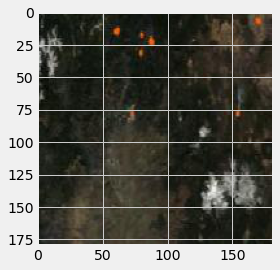

In [172]:
labeled_wildfire_image_3 = plt.imshow(wildfire_images_w_label_2[3])

# End

___

# Try hyperband directory
* Read in a model that was saved

In [173]:
filepath_hyperband = 'hyperband.hdf5'

In [174]:
# val_loss = mode = min, val_acc = mode = max
checkpoint_hyperband = ModelCheckpoint(filepath=filepath_hyperband,
                            monitor='val_loss',
                            verbose=1,
                            save_best_only=True,
                            mode='min')

In [175]:
callbacks_hyperband = [checkpoint_hyperband]

In [176]:
hist_hyperband = best_model.fit(x_train, 
                 y_train, 
                 batch_size=256, 
                 epochs=10, 
                 validation_split=0.2,
                     callbacks=callbacks_hyperband)

Epoch 1/10
18/18 [==============================] - ETA: 0s - loss: 0.0901 - accuracy: 0.9694
Epoch 00001: val_loss improved from inf to 0.21987, saving model to hyperband.hdf5
18/18 [==============================] - 91s 5s/step - loss: 0.0901 - accuracy: 0.9694 - val_loss: 0.2199 - val_accuracy: 0.9259
Epoch 2/10
18/18 [==============================] - ETA: 0s - loss: 0.0952 - accuracy: 0.9671
Epoch 00002: val_loss did not improve from 0.21987
18/18 [==============================] - 91s 5s/step - loss: 0.0952 - accuracy: 0.9671 - val_loss: 0.2265 - val_accuracy: 0.9360
Epoch 3/10
18/18 [==============================] - ETA: 0s - loss: 0.0826 - accuracy: 0.9716
Epoch 00003: val_loss did not improve from 0.21987
18/18 [==============================] - 97s 5s/step - loss: 0.0826 - accuracy: 0.9716 - val_loss: 0.2241 - val_accuracy: 0.9241
Epoch 4/10
18/18 [==============================] - ETA: 0s - loss: 0.0805 - accuracy: 0.9735
Epoch 00004: val_loss did not improve from 0.21987
1

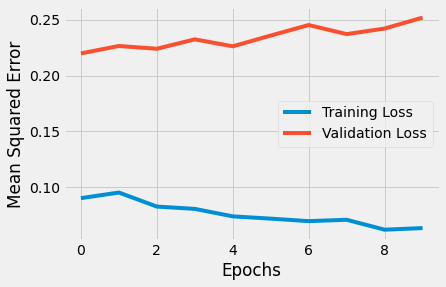

In [177]:
plt.plot(hist_hyperband.history['loss'], label='Training Loss')
plt.plot(hist_hyperband.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.show()

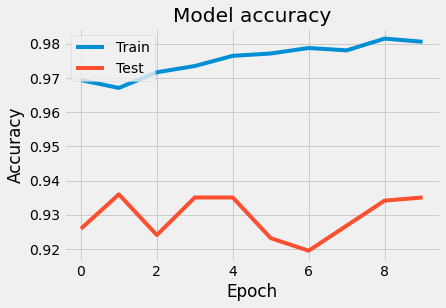

In [178]:
#Visualize the models accuracy
plt.plot(hist_hyperband.history['accuracy'])
plt.plot(hist_hyperband.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [179]:
best_model.evaluate(x_test, y_test)[0]

43/43 [==============================] - 6s 147ms/step - loss: 0.3284 - accuracy: 0.9122


0.3283870220184326

In [180]:
# These should all be No wildfire
actual_wildfire_predictions = []
for i in range(len(resized_images_no_fire)):
    actual_wildfire_predictions.append(best_model.predict(np.array([resized_images_no_fire[i]])))
#no_wildfire_prediction_1 = model.predict(np.array([resized_images_no_fire[0]]))

In [181]:
actual_wildfire_predictions

[array([[0.989494  , 0.01050596]], dtype=float32),
 array([[0.98013514, 0.01986483]], dtype=float32),
 array([[0.87272453, 0.12727547]], dtype=float32),
 array([[9.999187e-01, 8.134120e-05]], dtype=float32)]

### Look at the images to see if there should be no wildfire

#### Get the labeled images for the specified dates

In [182]:
images_w_fire_labels_path = 'images_w_fire_labels/'

In [183]:
wildfire_images_w_label = []

for i in no_fire_validation_dates:
    jpeg_file = images_w_fire_labels_path + i + '.jpg'
    im = imread(jpeg_file)
    wildfire_images_w_label.append(im)

In [184]:
actual_wildfire_predictions[0]

array([[0.989494  , 0.01050596]], dtype=float32)

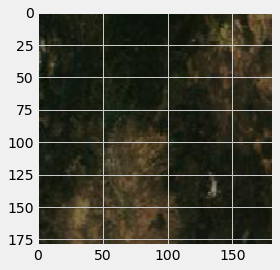

In [185]:
no_wildfire_image_0 = plt.imshow(no_wildfire_images_validation[0])

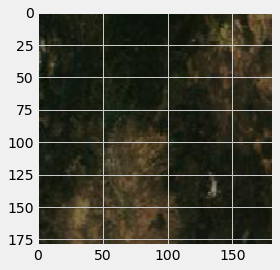

In [186]:
labeled_no_wildfire_image_0 = plt.imshow(wildfire_images_w_label[0])

In [187]:
actual_wildfire_predictions[1]

array([[0.98013514, 0.01986483]], dtype=float32)

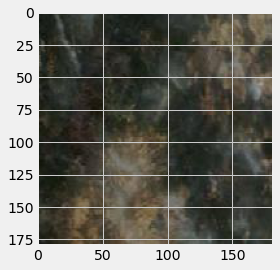

In [188]:
no_wildfire_image_1 = plt.imshow(no_wildfire_images_validation[1])

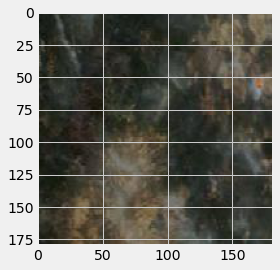

In [189]:
labeled_no_wildfire_image_1 = plt.imshow(wildfire_images_w_label[1])

In [190]:
actual_wildfire_predictions[2]

array([[0.87272453, 0.12727547]], dtype=float32)

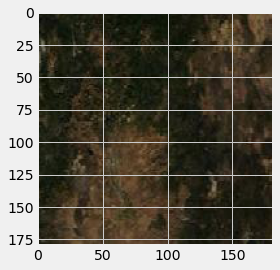

In [191]:
no_wildfire_image_2 = plt.imshow(no_wildfire_images_validation[2])

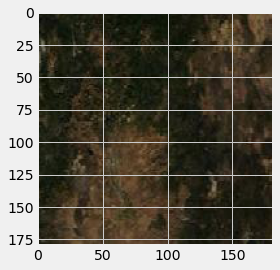

In [192]:
labeled_no_wildfire_image_2 = plt.imshow(wildfire_images_w_label[2])

In [193]:
actual_wildfire_predictions[3]

array([[9.999187e-01, 8.134120e-05]], dtype=float32)

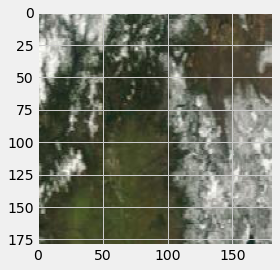

In [194]:
no_wildfire_image_3 = plt.imshow(no_wildfire_images_validation[3])

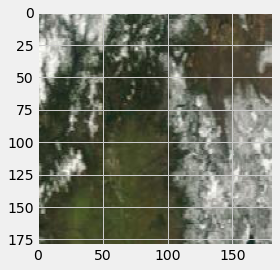

In [195]:
labeled_no_wildfire_image_3 = plt.imshow(wildfire_images_w_label[3])

### The below images were predicted to have wildfire and the labeled data should have the orange dot if there actually was a wildfire

In [196]:
resized_images_w_fire = []

for i in range(len(wildfire_images_validation)):
    #resized_images_w_fire.append(resize(wildfire_images_validation[i],(180,182,3)))
    resized_images_w_fire.append(resize(wildfire_images_validation[i],(180,180,3)))

In [197]:
# These should all be wildfire
actual_wildfire_predictions2 = []
for i in range(len(resized_images_w_fire)):
    actual_wildfire_predictions2.append(best_model.predict(np.array([resized_images_w_fire[i]])))
#no_wildfire_prediction_1 = model.predict(np.array([resized_images_no_fire[0]]))

In [198]:
actual_wildfire_predictions2

[array([[0.95818204, 0.0418179 ]], dtype=float32),
 array([[0.01577464, 0.9842254 ]], dtype=float32),
 array([[0.9592051 , 0.04079491]], dtype=float32),
 array([[0.95818204, 0.0418179 ]], dtype=float32)]

#### Get the labeled data images

In [199]:
wildfire_images_w_label_2 = []

for i in fire_validation_dates:
    jpeg_file = images_w_fire_labels_path + i + '.jpg'
    im = imread(jpeg_file)
    wildfire_images_w_label_2.append(im)

In [200]:
actual_wildfire_predictions2[0]

array([[0.95818204, 0.0418179 ]], dtype=float32)

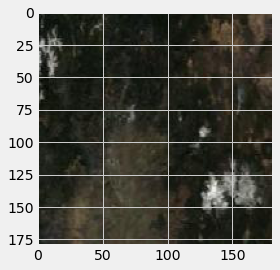

In [201]:
wildfire_image_0 = plt.imshow(wildfire_images_validation[0])

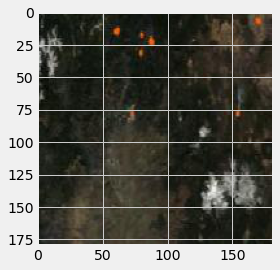

In [202]:
labeled_wildfire_image_0 = plt.imshow(wildfire_images_w_label_2[0])

In [203]:
actual_wildfire_predictions2[1]

array([[0.01577464, 0.9842254 ]], dtype=float32)

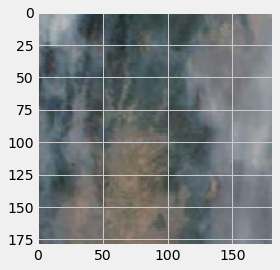

In [204]:
wildfire_image_1 = plt.imshow(wildfire_images_validation[1])

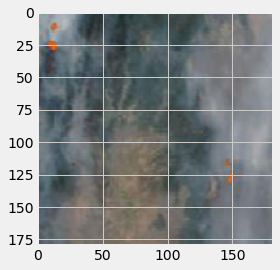

In [205]:
labeled_wildfire_image_1 = plt.imshow(wildfire_images_w_label_2[1])

In [206]:
actual_wildfire_predictions2[2]

array([[0.9592051 , 0.04079491]], dtype=float32)

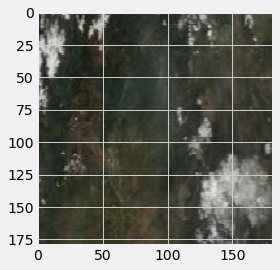

In [207]:
wildfire_image_2 = plt.imshow(wildfire_images_validation[2])

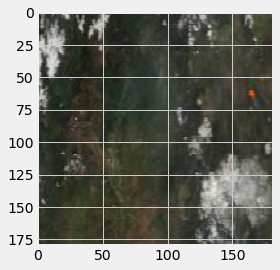

In [208]:
labeled_wildfire_image_2 = plt.imshow(wildfire_images_w_label_2[2])

In [209]:
actual_wildfire_predictions2[3]

array([[0.95818204, 0.0418179 ]], dtype=float32)

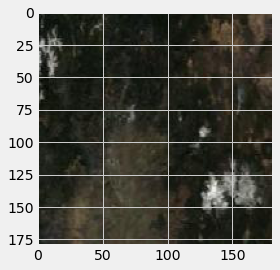

In [210]:
wildfire_image_3 = plt.imshow(wildfire_images_validation[3])

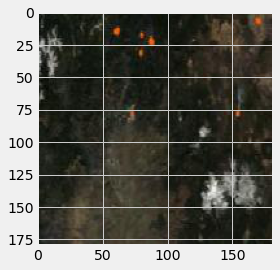

In [211]:
labeled_wildfire_image_3 = plt.imshow(wildfire_images_w_label_2[3])

# End

___

# 3/24/2022: I'm getting errors trying to fit so will retry with a good model (I got from above in another notebook), less data and not using one hot encode classes
* https://stackoverflow.com/questions/63600431/model-fit-typeerror-nonetype-object-is-not-callable

In [691]:
from keras_tuner import HyperModel

In [692]:
from tensorflow import keras
from tensorflow.keras.layers import (
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    MaxPooling2D
)

In [693]:
input_shape=(180,180,3)
num_classes = 2

In [694]:
model = keras.Sequential()

In [695]:
class CNNHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        model = keras.Sequential()
        model.add(
            Conv2D(filters=16,kernel_size=3,activation='relu',input_shape=self.input_shape)
        )
        model.add(
            Conv2D(filters=16,activation='relu',kernel_size=3
            )
        )
        model.add(MaxPooling2D(pool_size=2))
        model.add(
            Dropout(rate=hp.Float('dropout_1',min_value=0.2,max_value=0.2,default=0.2,))
        )
        model.add(
            Conv2D(filters=32,kernel_size=3,activation='relu')
        )
        model.add(
            Conv2D(
                filters=hp.Choice('num_filters',values=[32]),activation='relu',kernel_size=3)
        )
        model.add(MaxPooling2D(pool_size=2))
        model.add(
            Dropout(rate=hp.Float('dropout_2',min_value=0.4,max_value=0.4,default=0.4,))
        )
        model.add(Flatten())
        model.add(
            Dense(
                units=hp.Int('units',min_value=384,max_value=384,default=384),
                activation=hp.Choice('dense_activation',values=['tanh'],default='tanh'))
        )
        model.add(
            Dropout(
                rate=hp.Float('dropout_3',min_value=0.5,max_value=0.5,default=0.5,))
        )
        model.add(Dense(self.num_classes, activation='softmax'))

        model.compile(
            optimizer=keras.optimizers.Adam(
                hp.Float('learning_rate',min_value=0.00025,max_value=0.00025,sampling='LOG',default=0.00025)
            ),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy']
        )
        return model

hypermodel = CNNHyperModel(input_shape=input_shape, num_classes=num_classes)

### Choose the Tuner
### Hyperband
* Optimized version of random search
* Uses early-stopping to speed up the hyperparameter tuning process. 
* Main idea is to fit a large number of models for a small number of epochs and to only continue training for the models achieving the highest accuracy on the validation set

In [696]:
from keras_tuner.tuners import Hyperband

In [697]:
tuner = Hyperband(
    hypermodel,
    objective='val_accuracy',
    max_epochs=10,
    seed=1,
    executions_per_trial=2,
    directory='hyperband_3_25b',
    project_name='fire_overweighted'
)

In [698]:
tuner.search_space_summary()

Search space summary
Default search space size: 7
dropout_1 (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.2, 'step': None, 'sampling': None}
num_filters (Choice)
{'default': 32, 'conditions': [], 'values': [32], 'ordered': True}
dropout_2 (Float)
{'default': 0.4, 'conditions': [], 'min_value': 0.4, 'max_value': 0.4, 'step': None, 'sampling': None}
units (Int)
{'default': 384, 'conditions': [], 'min_value': 384, 'max_value': 384, 'step': 1, 'sampling': None}
dense_activation (Choice)
{'default': 'tanh', 'conditions': [], 'values': ['tanh'], 'ordered': False}
dropout_3 (Float)
{'default': 0.5, 'conditions': [], 'min_value': 0.5, 'max_value': 0.5, 'step': None, 'sampling': None}
learning_rate (Float)
{'default': 0.00025, 'conditions': [], 'min_value': 0.00025, 'max_value': 0.00025, 'step': None, 'sampling': 'log'}


In [699]:
N_EPOCH_SEARCH = 10

tuner.search(x_train, y_train, epochs=N_EPOCH_SEARCH, validation_split=0.2)

Trial 1 Complete [00h 05m 43s]
val_accuracy: 0.9371859133243561

Best val_accuracy So Far: 0.9371859133243561
Total elapsed time: 00h 05m 43s
INFO:tensorflow:Oracle triggered exit


In [700]:
# Show a summary of the search
tuner.results_summary()

# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model.
loss, accuracy = best_model.evaluate(x_test, y_test)

Results summary
Results in hyperband_3_25b/fire_overweighted
Showing 10 best trials
Trial summary
Hyperparameters:
dropout_1: 0.2
num_filters: 32
dropout_2: 0.4
units: 384
dense_activation: tanh
dropout_3: 0.5
learning_rate: 0.00025
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 0.9371859133243561
39/39 [==============================] - 5s 133ms/step - loss: 0.3092 - accuracy: 0.9172


# To save the best model (or at least a model)
* https://towardsdatascience.com/keras-callbacks-and-how-to-save-your-model-from-overtraining-244fc1de8608

In [702]:
from keras.callbacks import ModelCheckpoint

In [703]:
filepath = '3_25_2022_modelb.hdf5'

In [704]:
# val_loss = mode = min, val_acc = mode = max
checkpoint = ModelCheckpoint(filepath=filepath,
                            monitor='val_loss',
                            verbose=1,
                            save_best_only=True,
                            mode='min')

In [705]:
callbacks = [checkpoint]

In [706]:
hist = best_model.fit(x_train, 
                 y_train, 
                 batch_size=256, 
                 epochs=10, 
                 validation_split=0.2,
                     callbacks=callbacks)

Epoch 1/10
16/16 [==============================] - ETA: 0s - loss: 0.2414 - accuracy: 0.9208
Epoch 00001: val_loss improved from inf to 0.21553, saving model to 3_25_2022_modelb.hdf5
16/16 [==============================] - 74s 4s/step - loss: 0.2414 - accuracy: 0.9208 - val_loss: 0.2155 - val_accuracy: 0.9377
Epoch 2/10
16/16 [==============================] - ETA: 0s - loss: 0.2253 - accuracy: 0.9221
Epoch 00002: val_loss improved from 0.21553 to 0.20803, saving model to 3_25_2022_modelb.hdf5
16/16 [==============================] - 68s 4s/step - loss: 0.2253 - accuracy: 0.9221 - val_loss: 0.2080 - val_accuracy: 0.9367
Epoch 3/10
16/16 [==============================] - ETA: 0s - loss: 0.2190 - accuracy: 0.9243
Epoch 00003: val_loss did not improve from 0.20803
16/16 [==============================] - 68s 4s/step - loss: 0.2190 - accuracy: 0.9243 - val_loss: 0.2086 - val_accuracy: 0.9276
Epoch 4/10
16/16 [==============================] - ETA: 0s - loss: 0.2089 - accuracy: 0.9304
Ep

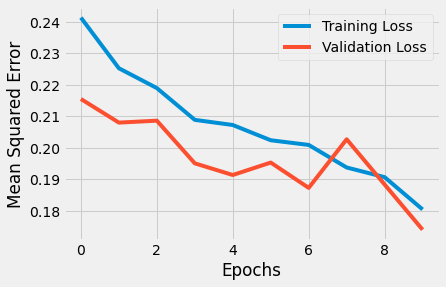

In [707]:
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.show()

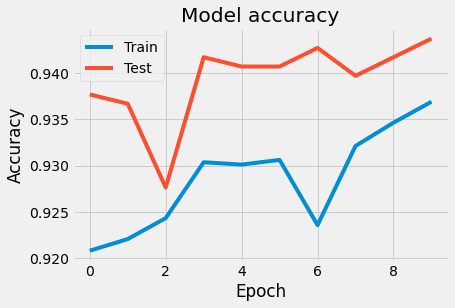

In [708]:
#Visualize the models accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [709]:
best_model.evaluate(x_test, y_test)[0]

39/39 [==============================] - 6s 142ms/step - loss: 0.2314 - accuracy: 0.9188


0.2313529998064041

# ACCORDING TO THE DOCUMENTATION OF MODELCHECKPOINT
* https://keras.io/api/callbacks/model_checkpoint/
* you're supposed to do:
1. compile
2. modelcheckpoint()
3. model.fit()
4. model.load_weights

# Model Validation

In [710]:
print(len(df_no_clouds_no_wildfires))

2827


### Get random index values from df_no_clouds_no_wildfires and df_wildfires

In [711]:
import random

In [712]:
df_wildfires_index_values = []
for i in df_wildfires.index:
    df_wildfires_index_values.append(i)
random_wildfire_images = [random.choice(df_wildfires_index_values),random.choice(df_wildfires_index_values),
                random.choice(df_wildfires_index_values),random.choice(df_wildfires_index_values)]
print(random_wildfire_images)

[38, 80, 215, 392]


In [713]:
df_no_clouds_no_wildfires_index_values = []
for i in df_no_clouds_no_wildfires.index:
    df_no_clouds_no_wildfires_index_values.append(i)
random_no_clouds_no_wildfires_images = [random.choice(df_no_clouds_no_wildfires_index_values),random.choice(df_no_clouds_no_wildfires_index_values),
                random.choice(df_no_clouds_no_wildfires_index_values),random.choice(df_no_clouds_no_wildfires_index_values)]
print(random_no_clouds_no_wildfires_images)

[1074, 1889, 1051, 2938]


In [714]:
# Load an image you want to classify from an image file
# I'm just getting 4 random dates where there are no wildfires and where there were wildfires
fire_1 = df_wildfires['ConvertedDate'][random_wildfire_images[0]]
fire_2 = df_wildfires['ConvertedDate'][random_wildfire_images[1]]
fire_3 = df_wildfires['ConvertedDate'][random_wildfire_images[2]]
fire_4 = df_wildfires['ConvertedDate'][random_wildfire_images[3]]
no_fire_1 = df_no_clouds_no_wildfires['ConvertedDate'][random_no_clouds_no_wildfires_images[0]]
no_fire_2 = df_no_clouds_no_wildfires['ConvertedDate'][random_no_clouds_no_wildfires_images[1]]
no_fire_3 = df_no_clouds_no_wildfires['ConvertedDate'][random_no_clouds_no_wildfires_images[2]]
no_fire_4 = df_no_clouds_no_wildfires['ConvertedDate'][random_no_clouds_no_wildfires_images[3]]

In [715]:
no_fire_validation_dates = [no_fire_1,no_fire_2,no_fire_3,no_fire_4]
fire_validation_dates = [fire_1,fire_2,fire_3,fire_4]

In [716]:
no_fire_validation_dates

['2013-12-23', '2016-12-21', '2013-11-28', '2020-11-16']

In [717]:
no_wildfire_images_validation = []

for i in no_fire_validation_dates:
    jpeg_file = images_wo_fire_labels_path + i + '.jpg'
    im = imread(jpeg_file)
    no_wildfire_images_validation.append(im)

In [718]:
wildfire_images_validation = []

for i in fire_validation_dates:
    jpeg_file = images_wo_fire_labels_path + i + '.jpg'
    im = imread(jpeg_file)
    wildfire_images_validation.append(im)

#### Resize Images for prediction

In [719]:
from skimage.transform import resize

In [720]:
resized_images_no_fire = []

for i in range(len(no_wildfire_images_validation)):
    #resized_images_no_fire.append(resize(no_wildfire_images_validation[i],(180,182,3)))
    resized_images_no_fire.append(resize(no_wildfire_images_validation[i],(180,180,3)))

In [721]:
# These should all be No wildfire
actual_wildfire_predictions = []
for i in range(len(resized_images_no_fire)):
    actual_wildfire_predictions.append(best_model.predict(np.array([resized_images_no_fire[i]])))
#no_wildfire_prediction_1 = model.predict(np.array([resized_images_no_fire[0]]))

In [722]:
actual_wildfire_predictions

[array([[0.8978432 , 0.10215686]], dtype=float32),
 array([[0.9678527 , 0.03214728]], dtype=float32),
 array([[0.92209715, 0.07790283]], dtype=float32),
 array([[0.6377333 , 0.36226672]], dtype=float32)]

### Look at the images to see if there should be no wildfire

#### Get the labeled images for the specified dates

In [723]:
images_w_fire_labels_path = 'images_w_fire_labels/'

In [724]:
wildfire_images_w_label = []

for i in no_fire_validation_dates:
    jpeg_file = images_w_fire_labels_path + i + '.jpg'
    im = imread(jpeg_file)
    wildfire_images_w_label.append(im)

In [725]:
actual_wildfire_predictions[0]

array([[0.8978432 , 0.10215686]], dtype=float32)

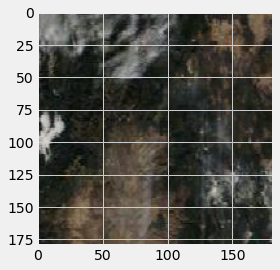

In [726]:
no_wildfire_image_0 = plt.imshow(no_wildfire_images_validation[0])

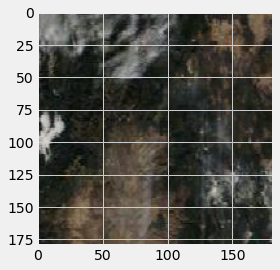

In [727]:
labeled_no_wildfire_image_0 = plt.imshow(wildfire_images_w_label[0])

In [728]:
actual_wildfire_predictions[1]

array([[0.9678527 , 0.03214728]], dtype=float32)

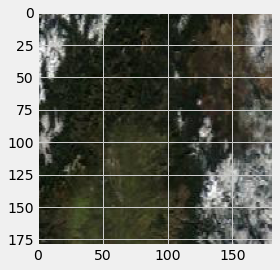

In [729]:
no_wildfire_image_1 = plt.imshow(no_wildfire_images_validation[1])

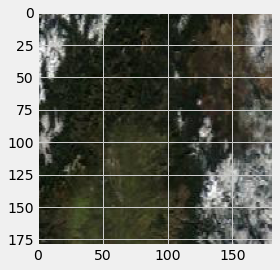

In [730]:
labeled_no_wildfire_image_1 = plt.imshow(wildfire_images_w_label[1])

In [731]:
actual_wildfire_predictions[2]

array([[0.92209715, 0.07790283]], dtype=float32)

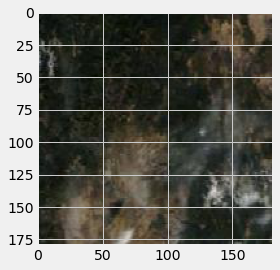

In [732]:
no_wildfire_image_2 = plt.imshow(no_wildfire_images_validation[2])

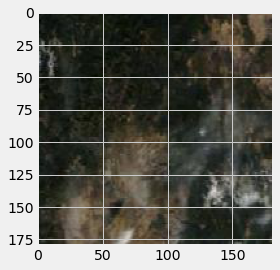

In [733]:
labeled_no_wildfire_image_2 = plt.imshow(wildfire_images_w_label[2])

In [734]:
actual_wildfire_predictions[3]

array([[0.6377333 , 0.36226672]], dtype=float32)

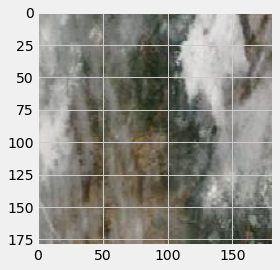

In [735]:
no_wildfire_image_3 = plt.imshow(no_wildfire_images_validation[3])

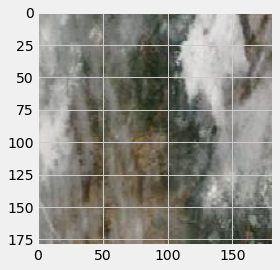

In [736]:
labeled_no_wildfire_image_3 = plt.imshow(wildfire_images_w_label[3])

### The below images should have the orange dot if there actually was a wildfire

In [737]:
resized_images_w_fire = []

for i in range(len(wildfire_images_validation)):
    #resized_images_w_fire.append(resize(wildfire_images_validation[i],(180,182,3)))
    resized_images_w_fire.append(resize(wildfire_images_validation[i],(180,180,3)))

In [738]:
# These should all be wildfire
actual_wildfire_predictions2 = []
for i in range(len(resized_images_w_fire)):
    actual_wildfire_predictions2.append(best_model.predict(np.array([resized_images_w_fire[i]])))
#no_wildfire_prediction_1 = model.predict(np.array([resized_images_no_fire[0]]))

In [739]:
actual_wildfire_predictions2

[array([[0.88038164, 0.11961842]], dtype=float32),
 array([[0.895939  , 0.10406103]], dtype=float32),
 array([[0.4913724 , 0.50862753]], dtype=float32),
 array([[0.38208693, 0.6179131 ]], dtype=float32)]

#### Get the labeled data images

In [740]:
wildfire_images_w_label_2 = []

for i in fire_validation_dates:
    jpeg_file = images_w_fire_labels_path + i + '.jpg'
    im = imread(jpeg_file)
    wildfire_images_w_label_2.append(im)

In [741]:
actual_wildfire_predictions2[0]

array([[0.88038164, 0.11961842]], dtype=float32)

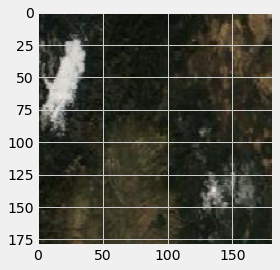

In [742]:
wildfire_image_0 = plt.imshow(wildfire_images_validation[0])

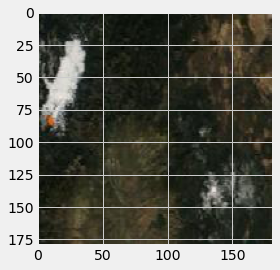

In [743]:
labeled_wildfire_image_0 = plt.imshow(wildfire_images_w_label_2[0])

In [744]:
actual_wildfire_predictions2[1]

array([[0.895939  , 0.10406103]], dtype=float32)

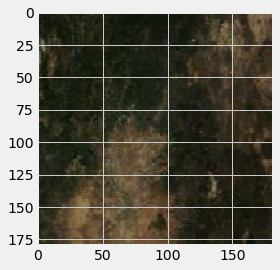

In [745]:
wildfire_image_1 = plt.imshow(wildfire_images_validation[1])

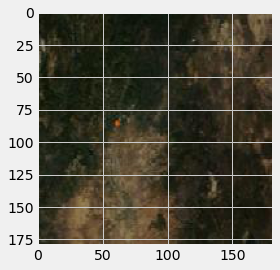

In [746]:
labeled_wildfire_image_1 = plt.imshow(wildfire_images_w_label_2[1])

In [747]:
actual_wildfire_predictions2[2]

array([[0.4913724 , 0.50862753]], dtype=float32)

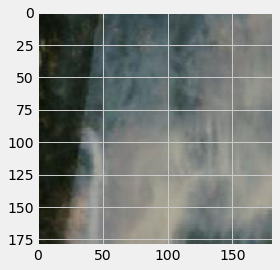

In [748]:
wildfire_image_2 = plt.imshow(wildfire_images_validation[2])

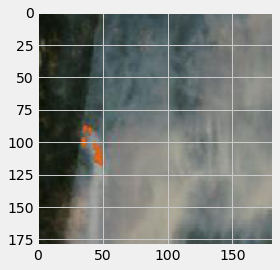

In [749]:
labeled_wildfire_image_2 = plt.imshow(wildfire_images_w_label_2[2])

In [750]:
actual_wildfire_predictions2[3]

array([[0.38208693, 0.6179131 ]], dtype=float32)

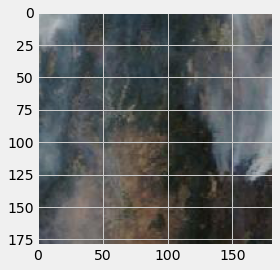

In [751]:
wildfire_image_3 = plt.imshow(wildfire_images_validation[3])

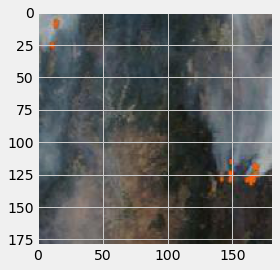

In [752]:
labeled_wildfire_image_3 = plt.imshow(wildfire_images_w_label_2[3])

# End

___

# Didn't do anything with the below
# 3/23/2022:
* https://www.sicara.ai/blog/hyperparameter-tuning-keras-tuner

* Each input image will go through two convolutional blocks (2 convolution layers followed by a pooling layer) and a dropout layer for regularization purposes. 
* Finally, each output is flattened and goes through a dense layer that classify the image into one of the 2 classes.

In [78]:
from tensorflow import keras
from tensorflow.keras.layers import (
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    MaxPooling2D
)

In [79]:
input_shape=(180,180,3)
num_classes = 2

In [80]:
model = keras.Sequential()

In [ ]:
# Not running these

In [ ]:
model.add(Conv2D(
        filters=16,
        kernel_size=3,
        activation='relu',
        input_shape=input_shape)
)

In [ ]:
model.add(Conv2D(16, 3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(rate=0.25))
model.add(Conv2D(32, 3, activation='relu'))
model.add(Conv2D(64, 3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(NUM_CLASSES, activation='softmax'))

### Hyperparameter Turning
* For this model, 6 hyperparameters can be tuned:
    * Dropout rate for the three dropout layers
    * Number of filters for the convolutional layers
    * Number of units for the dense layer
    * The activation function

In [ ]:
filters=hp.Choice(
    'num_filters',
    values=[32, 64],
    default=64,
)

### Dense Layer
* Two hyperparameters: Number of units and activation function

In [ ]:
Dense(
    units=hp.Int('units',min_value=32,max_value=512,step=32,default=128),
    activation=hp.Choice('dense_activation',values=['relu', 'tanh', 'sigmoid'],default='relu')
)

### Model Compilation
* This is where the optimizer, loss function and the metric are defined

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

### Learning Rate
* Represents how fast the learning algorithm progresses
* Usually, the learning rate is chosen on a log scale. This prior knowledge can be incorporated in the search through the setting of the sampling method

In [ ]:
hp.Float(
    'learning_rate',
    min_value=1e-5,
    max_value=1e-2,
    sampling='LOG',
    default=1e-3
)

# To here